In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
from os.path import join, abspath
from os import pardir, curdir, mkdir
import sys
import healpy as hp
from scipy import interpolate

In [6]:
root_data_dir = abspath(join(pardir, "Data"))
comp_dir = join(root_data_dir, "Completeness")

In [7]:
name = "Effective-Volume"
data_dir = join(root_data_dir, name)
try:
  mkdir(data_dir)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Creating Effective-Volume dir in Data dir


In [16]:
comp_A = vaex.open(join(comp_dir, "comp-A.hdf5"))
comp_F = vaex.open(join(comp_dir, "comp-F.hdf5"))
comp_G = vaex.open(join(comp_dir, "comp-G.hdf5"))
comp_G

#,index,comp,dm
0,0,-5.353125429564271e-22,-2.0
1,0,-5.353125429564271e-22,-1.8585858585858586
2,0,-5.353125429564271e-22,-1.7171717171717171
3,0,-5.353125429564271e-22,-1.5757575757575757
4,0,-5.353125429564271e-22,-1.4343434343434343
...,...,...,...
"4,795",47,0.9166514371672921,11.434343434343434
"4,796",47,0.9166514371672921,11.575757575757574
"4,797",47,0.9166514371672921,11.717171717171716
"4,798",47,0.9166514371672921,11.858585858585858


In [18]:
# add distance column in kpc
distance = np.power(10, (comp_A.dm.to_numpy()-10)/5)
comp_A["distance"] = distance
distance = np.power(10, (comp_F.dm.to_numpy()-10)/5)
comp_F["distance"] = distance
distance = np.power(10, (comp_G.dm.to_numpy()-10)/5)
comp_G["distance"] = distance
comp_G

#,index,comp,dm,distance
0,0,-5.353125429564271e-22,-2.0,0.003981071705534973
1,0,-5.353125429564271e-22,-1.8585858585858586,0.004248961816344008
2,0,-5.353125429564271e-22,-1.7171717171717171,0.004534878508128582
3,0,-5.353125429564271e-22,-1.5757575757575757,0.004840034806709947
4,0,-5.353125429564271e-22,-1.4343434343434343,0.005165725363573423
...,...,...,...,...
"4,795",47,0.9166514371672921,11.434343434343434,1.9358365565687827
"4,796",47,0.9166514371672921,11.575757575757574,2.0661008441791697
"4,797",47,0.9166514371672921,11.717171717171716,2.2051307399030446
"4,798",47,0.9166514371672921,11.858585858585858,2.3535160898679104


In [20]:
comp = [comp_A, comp_F, comp_G]
comp

[#      index    comp                    dm                   distance
 0      0        2.2809704437388014e-20  -2.0                 0.003981071705534973
 1      0        2.2809704437388014e-20  -1.8585858585858586  0.004248961816344008
 2      0        2.2809704437388014e-20  -1.7171717171717171  0.004534878508128582
 3      0        2.2809704437388014e-20  -1.5757575757575757  0.004840034806709947
 4      0        2.2809704437388014e-20  -1.4343434343434343  0.005165725363573423
 ...    ...      ...                     ...                  ...
 4,795  47       0.7951043773921733      11.434343434343434   1.9358365565687827
 4,796  47       0.800424204618738       11.575757575757574   2.0661008441791697
 4,797  47       0.8006826537812374      11.717171717171716   2.2051307399030446
 4,798  47       0.7982761329001654      11.858585858585858   2.3535160898679104
 4,799  47       0.794752348382697       12.0                 2.51188643150958,
 #      index    comp                   dm  

In [37]:
# create function that gives completeness given GLAN, GLON, and distance
import healpy as hp
from scipy import interpolate
# healpix config
LEVEL = 1
NSIDE = 2**LEVEL
NPIX = hp.nside2npix(NSIDE)
# GLAN, GLON in rad
# 0 = A, 1 = F, 2 = G
comp_index = []
for j in range(3):
  func = []
  for i in range(NPIX):
    comp_i = comp[j][comp[j]["index"] == i]
    comp_i
    f = interpolate.interp1d(comp_i["distance"].to_numpy(), comp_i["comp"].to_numpy(), kind="cubic")
    func.append(f)
  comp_index.append(func)


In [64]:
# GLAT, GLON in rad, spec=0 for A, 1 for F, and 2 for G, distance in kpc
def completeness(GLAT, GLON, distance, spec):
  if isinstance(GLAT, (np.ndarray, list)) and isinstance(GLON, (np.ndarray,list)) and isinstance(distance, (np.ndarray, list)):
    if len(GLAT) != len(GLON) != len(distance):
      raise TypeError("GLAN, GLON, and/or distance dimension don't match")
    result = np.array(list(map(lambda x: completeness(x[0], x[1], x[2], spec), zip(GLAT, GLON, distance))))
    return result
  elif isinstance(GLAT, (int, float)) and isinstance(GLON, (int, float)) and isinstance(distance, (int, float)):
    phi = GLON
    theta = np.pi/2 - GLAT
    index = hp.ang2pix(NSIDE, theta=theta, phi=phi).astype(int)
    f = comp_index[spec][index]
    try:
      result = f(distance)
    except ValueError:
      result = 0
    if result > 1:
      return 1
    elif result <0:
      return 0
    return result
  else:
    raise TypeError("input error")

In [2]:
Z = 0.2
R = 0.15

In [81]:
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 102) #edges
er = np.linspace(0, R, 102)
ephi = np.linspace(0, np.pi*2, 102)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2
phi = (ephi[:-1]+ephi[1:])/2

In [93]:
# volume like a slice of pie
# Vol = base*heigh = dphi/2*(r1^2-r0^2)*dz
# for A for 1st index, F 2nd, G 3rd
vol = np.empty((3, len(z), len(r), len(phi)))
real_vol = np.empty((len(z), len(r), len(phi)))
dphi = ephi[1]-ephi[0]
dz = ez[1]-ez[0]

for i, zz in enumerate(z):
  print(i, zz, end=" | ")
  for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
    v = dphi/2*(r_out**2-r_in**2)*dz*np.ones_like(phi)
    glat = np.arctan(zz/rr)*np.ones_like(phi)
    glon = phi
    distance =np.sqrt(rr**2+zz**2)*np.ones_like(phi)
    c = np.empty((3, len(phi)))
    for k in range(3):
      c[k] = completeness(glat, glon, distance, k)
      vol[k, i, j] = v*c[k]
    real_vol[i, j] = v


0 -0.19801980198019803 | 1 -0.19405940594059407 | 2 -0.1900990099009901 | 3 -0.18613861386138614 | 4 -0.18217821782178217 | 5 -0.17821782178217824 | 6 -0.17425742574257427 | 7 -0.1702970297029703 | 8 -0.16633663366336635 | 9 -0.16237623762376238 | 10 -0.15841584158415845 | 11 -0.15445544554455448 | 12 -0.15049504950495052 | 13 -0.14653465346534655 | 14 -0.1425742574257426 | 15 -0.13861386138613863 | 16 -0.13465346534653466 | 17 -0.1306930693069307 | 18 -0.12673267326732673 | 19 -0.12277227722772278 | 20 -0.11881188118811882 | 21 -0.11485148514851487 | 22 -0.1108910891089109 | 23 -0.10693069306930694 | 24 -0.10297029702970298 | 25 -0.09900990099009901 | 26 -0.09504950495049505 | 27 -0.0910891089108911 | 28 -0.08712871287128714 | 29 -0.08316831683168319 | 30 -0.07920792079207922 | 31 -0.07524752475247526 | 32 -0.0712871287128713 | 33 -0.06732673267326733 | 34 -0.06336633663366337 | 35 -0.0594059405940594 | 36 -0.05544554455445545 | 37 -0.0514851485148515 | 38 -0.04752475247524754 | 39 -0

In [94]:
vz = [np.sum(vol[k], axis=(1, 2)) for k in range(3)]
real_vz = np.sum(real_vol, axis=(1, 2))

In [99]:
compz = [vz[i]/real_vz for i in range(3)]

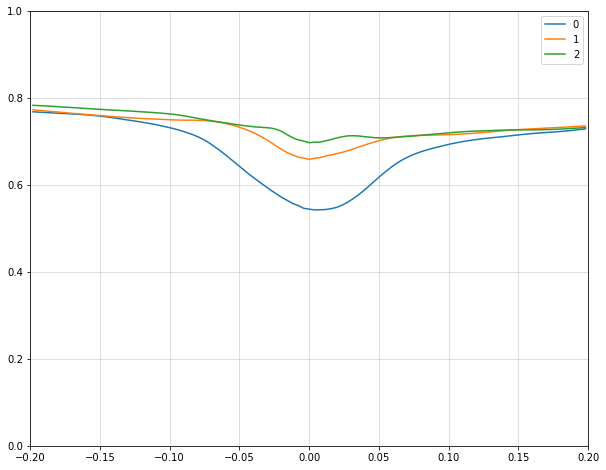

In [100]:
plt.figure(figsize=(10,8))
for i in range(3):
  plt.plot(z, compz[i], label=i)
plt.ylim(0,1)
plt.xlim(-0.2, 0.2)
plt.grid(alpha=0.5)
plt.legend()

In [103]:
df = vaex.from_arrays(z=z, A=compz[0], F=compz[1], G=compz[2])
df

#,z,A,F,G
0,-0.19801980198019803,0.767990388366686,0.7725332692437439,0.7829643710086119
1,-0.19405940594059407,0.7672513717483699,0.7714115429778209,0.7823294594731213
2,-0.1900990099009901,0.7666072254044739,0.7703100815668459,0.78171264590061
3,-0.18613861386138614,0.76591767736503,0.7691910180419987,0.7810209447680974
4,-0.18217821782178217,0.7651772253629564,0.768026164556425,0.780238638596184
...,...,...,...,...
96,0.18217821782178217,0.72335904191406,0.7325723023584791,0.7286921868339422
97,0.18613861386138614,0.7245454967096219,0.7332793729901006,0.7293937653206298
98,0.1900990099009901,0.7258575183500154,0.733998301899157,0.7301434411218999
99,0.19405940594059407,0.7273712092274773,0.7347421885389851,0.7309390639500167


In [104]:
df.export(join(data_dir, "comp.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.04s =  0.0m =  0.0h
 